In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from util import compute_batch_accuracy

# Multilayer Neural Network

## Settings and Data Loading

In [4]:
# Hyperparameters
batch_size = 256
learning_rate = 0.1
num_epochs = 10
random_seed = 0
dropout = False
batchnorm = True

# Architecture
num_features = 28 * 28
num_classes = 10
num_hidden = [128, 256]

train = datasets.MNIST(root='data',
                        train=True, 
                        transform=transforms.ToTensor(),  
                        download=True)

test = datasets.MNIST(root='data',
                        train=False, 
                        transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train,
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test, 
                         batch_size=batch_size, 
                         shuffle=False)

## Model Definition and Training

In [5]:
class MultilayerNet(torch.nn.Module):

    def __init__(self, num_features, num_classes, num_hidden, 
                dropout=False, batchnorm=False):
        super(MultilayerNet, self).__init__()
        self.linear_1 = torch.nn.Linear(num_features, num_hidden[0])
        self.linear_1_bn = torch.nn.BatchNorm1d(num_hidden[0])

        self.linear_2 = torch.nn.Linear(num_hidden[0], num_hidden[1])
        self.linear_2_bn = torch.nn.BatchNorm1d(num_hidden[1])

        self.linear_out = torch.nn.Linear(num_hidden[1], num_classes)

        self.dropout = dropout
        self.batchnorm = batchnorm

    def forward(self, x):
        ## flatten
        x = x.view(-1, num_features)
        ## 1st hidden layer 
        out = torch.relu(self.linear_1(x))
        if self.batchnorm:
            out = self.linear_1_bn(out)
        out = torch.relu(out)
        if self.dropout:
            out = torch.nn.functional.dropout(out)

        ## 2nd hidden layer
        out = self.linear_2(out)
        if self.batchnorm:
            out = self.linear_2_bn(out)
        out = torch.relu(out)    
        if self.dropout:
            out = torch.nn.functional.dropout(out)
        
        ## Output layer
        logits = self.linear_out(out)
        return logits

In [6]:
torch.manual_seed(random_seed)
model = MultilayerNet(
    num_features, num_classes, num_hidden, 
    dropout=dropout, 
    batchnorm = batchnorm
)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
cost_fn = torch.nn.CrossEntropyLoss()

train_acc = []
test_acc = []

for epoch in range(num_epochs):
    for batch_idx, (X_train, y_train) in enumerate(train_loader):

        # Feed forward
        logits = model(X_train)

        # Compute the cost
        cost = cost_fn(logits, y_train)
        optimizer.zero_grad()
        cost.backward()
        
        # Update the weights
        optimizer.step()
        
        # Logging
        if batch_idx % 50 == 0:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch + 1, num_epochs, batch_idx, batch_size, cost))

    acc = compute_batch_accuracy(model, train_loader)
    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
        epoch + 1, num_epochs, acc
    ))
    train_acc.append(acc)
    test_acc.append(compute_batch_accuracy(model, test_loader))

Epoch: 001/010 | Batch 000/256 | Cost: 2.3611
Epoch: 001/010 | Batch 050/256 | Cost: 0.3678
Epoch: 001/010 | Batch 100/256 | Cost: 0.2125
Epoch: 001/010 | Batch 150/256 | Cost: 0.2408
Epoch: 001/010 | Batch 200/256 | Cost: 0.1173
Epoch: 001/010 training accuracy: 96.62%
Epoch: 002/010 | Batch 000/256 | Cost: 0.1611
Epoch: 002/010 | Batch 050/256 | Cost: 0.0838
Epoch: 002/010 | Batch 100/256 | Cost: 0.1095
Epoch: 002/010 | Batch 150/256 | Cost: 0.0852
Epoch: 002/010 | Batch 200/256 | Cost: 0.1425
Epoch: 002/010 training accuracy: 97.93%
Epoch: 003/010 | Batch 000/256 | Cost: 0.0820
Epoch: 003/010 | Batch 050/256 | Cost: 0.0997
Epoch: 003/010 | Batch 100/256 | Cost: 0.0585
Epoch: 003/010 | Batch 150/256 | Cost: 0.0650
Epoch: 003/010 | Batch 200/256 | Cost: 0.0851
Epoch: 003/010 training accuracy: 98.47%
Epoch: 004/010 | Batch 000/256 | Cost: 0.0399
Epoch: 004/010 | Batch 050/256 | Cost: 0.0400
Epoch: 004/010 | Batch 100/256 | Cost: 0.0427
Epoch: 004/010 | Batch 150/256 | Cost: 0.0861
Epo

In [8]:
print('Test accuracy: %.2f%%' % (compute_batch_accuracy(model, test_loader)))

Test accuracy: 97.50%


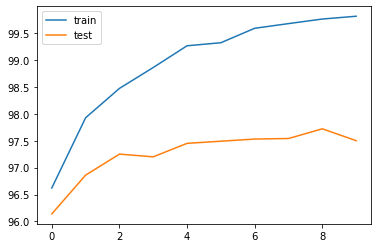

In [9]:
plt.plot(train_acc, label="train")
plt.plot(test_acc, label="test")
plt.legend()
plt.show()